In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import imageio
import moviepy.editor as mp
import ffmpy

import os
from math import * 
os.getcwd()
print("The current directory is: ")
print(os.getcwd())
path_parent = os.path.dirname(os.getcwd())
if path_parent.endswith("Abaqus-Macromechanics-Project"):
    os.chdir(path_parent) 
    print("Moving up to the parent directory")
    print(os.getcwd())

The current directory is: 
c:\Users\springnuance\Desktop\Abaqus-Macromechanics-Project\notebooks
Moving up to the parent directory
c:\Users\springnuance\Desktop\Abaqus-Macromechanics-Project


In [2]:
from stage0_configs import *
from modules.SOO_SIM import *
from modules.helper import *
from modules.hardeningLaws import *
# Plotting error over iterations
from modules.stoploss import *

info = main_config()

taskName = "A4" # A1 A2 A3 A4

if taskName == "A1":
    info['targetPath'] = "SOO_targets/DP1000_room_Swift_NDBR50_curve2"
    info['resultPath'] = "SOO_results/DP1000_room_Swift_NDBR50_curve2"

if taskName == "A2":
    info['targetPath'] = "SOO_targets/DP1000_room_SwiftVoce_NDBR50_curve2"
    info['resultPath'] = "SOO_results/DP1000_room_SwiftVoce_NDBR50_curve2"

if taskName == "A3":
    info['targetPath'] = "SOO_targets/DP1000_room_SwiftVoce_NDBR50_curve1"
    info['resultPath'] = "SOO_results/DP1000_room_SwiftVoce_NDBR50_curve1"

if taskName == "A4":
    info['targetPath'] = "SOO_targets/DP1000_400C_SwiftVoce_NDBR50_curve1"
    info['resultPath'] = "SOO_results/DP1000_400C_SwiftVoce_NDBR50_curve1"




Welcome to the Abaqus parameter calibration project


The configurations you have chosen: 

+------------------------+----------------+
|     Global Configs     |  User choice   |
+------------------------+----------------+
|    SLURM iteration     | one_node_small |
| Number of initial sims |      100       |
|  Initial sims spacing  |     10000      |
|   Optimize strategy    |      SOO       |
|        Material        |  DP1000_room   |
|     Hardening law      |     Swift      |
|        Geometry        |     NDBR50     |
|      Curve index       |       2        |
|     Optimizer name     |       BO       |
|   Deviation percent    |       2        |
+------------------------+----------------+

Generating necessary directories

The path to your main project folder is

c:\Users\springnuance\Desktop\Abaqus-Macromechanics-Project



In [3]:
# Add column force,N to the target curve
# Create new dataframe
df = pd.DataFrame(columns=['displacement/mm', 'force/kN', 'force/N'])
FD_targetCurve = pd.read_csv(f"{info['targetPath']}/FD_Curve.csv")
df['displacement/mm'] = FD_targetCurve['displacement/mm']
df['force/kN'] = FD_targetCurve['force/N'] * 1e-3
df['force/N'] = FD_targetCurve['force/N']
df.to_csv(f"{info['targetPath']}/FD_Curve.csv",index=False)

In [6]:
deviationPercent = 3
FD_Curve_iteration_errors = []
flowCurve_iteration_errors = []
stop_check = []

resultPath = info['resultPath']
targetPath = info['targetPath']

FD_targetCurve = pd.read_csv(f"{targetPath}/FD_Curve.csv")
expDisplacement = FD_targetCurve['displacement/mm']
expForce = FD_targetCurve['force/N']

FD_targetCurve = {}
FD_targetCurve['displacement'] = expDisplacement
FD_targetCurve['force'] = expForce

iteration_original_FD_Curves = np.load(f"{resultPath}/iteration/common/FD_Curves_smooth.npy", allow_pickle=True).tolist()
iteration_interpolated_FD_Curves = interpolating_FD_Curves(iteration_original_FD_Curves, FD_targetCurve)

iter = 1
for param in iteration_original_FD_Curves:
    FD_Curve_iteration_errors.append(lossFD(iteration_interpolated_FD_Curves[param]['displacement'], iteration_interpolated_FD_Curves[param]['force'], expForce))
    if stopFD(expForce, iteration_interpolated_FD_Curves[param]['force'], deviationPercent):
        stop_check.append(iter)
    iter += 1

if taskName != "A4":
    flow_targetCurve = pd.read_csv(f"{targetPath}/flowCurve.csv")
    expStrain = flow_targetCurve['strain/-']
    expStress = flow_targetCurve['stress/MPa']

    flow_targetCurve = {}
    flow_targetCurve['strain'] = expStrain
    flow_targetCurve['stress'] = expStress

    iteration_original_flowCurves = np.load(f"{resultPath}/iteration/common/flowCurves.npy", allow_pickle=True).tolist()
    iteration_interpolated_flowCurves = interpolating_flowCurves(iteration_original_flowCurves, flow_targetCurve)

    for param in iteration_original_FD_Curves:
        flowCurve_iteration_errors.append(lossFlow(iteration_interpolated_flowCurves[param]['strain'], iteration_interpolated_flowCurves[param]['stress'], expStress))

In [8]:
fontsize = 15

if np.any(len(stop_check)) == 0:
    print(f"No iterations satisfy the {deviationPercent}% deviation stop criterion")
else:
    print(f"Iterations that satisfy the stop criterion: {stop_check}")

# write to xlsx file loss of last five iterations. First column is iteration, second column is loss
df = pd.DataFrame({'Iteration': range(len(FD_Curve_iteration_errors) - 5, len(FD_Curve_iteration_errors) + 1), 'FD curve\nloss': FD_Curve_iteration_errors[-6:]})

# Make iteraton as index
df.set_index('Iteration', inplace=True)

df.head()

df.to_excel(f"notebooks/last_5_iteration_loss/{taskName}_loss.xlsx")

print("Finish saving the loss of last five iterations")

No iterations satisfy the 3% deviation stop criterion
Finish saving the loss of last five iterations


[]


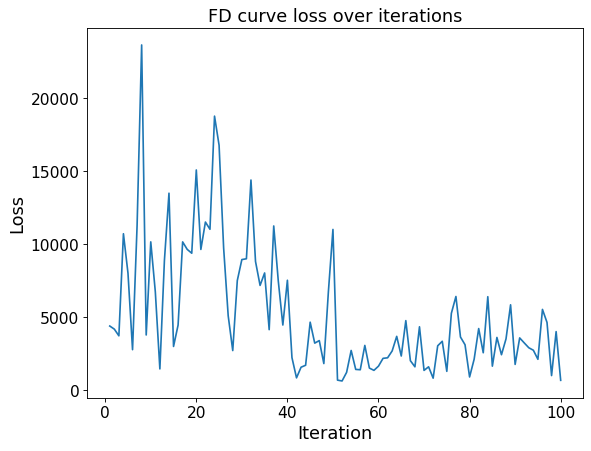

In [9]:
figure(figsize=(8, 6), dpi=80)

fontsize= 14
plt.plot(range(1, len(FD_Curve_iteration_errors) + 1), FD_Curve_iteration_errors,  label='Error')
plt.title('FD curve loss over iterations', fontsize=fontsize+2)
#plt.xlim([-1, len(iteration_errors)])
plt.xlabel('Iteration', fontsize=fontsize+2)
plt.ylabel('Loss', fontsize=fontsize+2)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
print(stop_check)

In [ ]:
# Animations
numberOfIterations = len(iteration_original_FD_Curves)

for iterName in range(1, numberOfIterations + 1):
    iterIndex = iterName - 1
    figure(figsize=(8, 6), dpi=80)

    fontsize= 14
    plt.plot(range(1, iterName + 1), FD_Curve_iteration_errors[0:iterIndex+1], label=f'Iteration {iterName}\nLoss = {FD_Curve_iteration_errors[iterIndex]:.2f}')
    plt.title('FD curve loss over iterations', fontsize=fontsize+2)
    plt.xlabel('Iteration', fontsize=fontsize+2)
    plt.ylabel('Loss', fontsize=fontsize+2)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    if taskName == "A1":
        plt.ylim([0, 12000])
        plt.xlim([0, numberOfIterations+1])
    
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.legend(fontsize=fontsize, loc=1)

    plt.savefig(f'notebooks/iteration_evolution/{taskName}_results/FD_loss/iter_{iterName}.png', 
        transparent = False,  
        facecolor = 'white'
        )
    plt.close()

frames = []
for iterName in range(1, numberOfIterations + 1):
    image = imageio.v2.imread(f'notebooks/iteration_evolution/{taskName}_results/FD_loss/iter_{iterName}.png')
    frames.append(image)

duration = []
if numberOfIterations < 100:
    for i in range(numberOfIterations-1):
        duration.append(300)
    duration.append(3000)
if numberOfIterations >= 100 and numberOfIterations < 200:
    for i in range(numberOfIterations-1):
        duration.append(200)
    duration.append(3000)
if numberOfIterations >= 200 and numberOfIterations < 300:
    for i in range(numberOfIterations-1):
        duration.append(100)
    duration.append(3000)

imageio.mimsave(f'notebooks/iteration_evolution/{taskName}_FD_loss_results.gif', 
                frames, 
                duration = duration,  # ms per image
                loop = 0
                )

# Remove the video if it exists
if os.path.exists(f'notebooks/iteration_evolution/{taskName}_FD_loss_results.mp4'):
     os.remove(f'notebooks/iteration_evolution/{taskName}_FD_loss_results.mp4')
     
ff = ffmpy.FFmpeg(
     executable=f"{os.getcwd()}/notebooks/ffmpeg",
     inputs={f'notebooks/iteration_evolution/{taskName}_FD_loss_results.gif': None},
     outputs={f'notebooks/iteration_evolution/{taskName}_FD_loss_results.mp4': '-pix_fmt yuv420p'}
)
ff.run()

(None, None)